In [1]:
import pandas as pd # To structure and manipulated data in a DataFrame format
import geopandas as gpd # To work with spatial data in a DataFrame
from geopandas import GeoDataFrame # To create a GeoDataFrame from a DataFrame
from shapely.geometry import LineString # To create line geometries that can be used in a GeoDataFrame
import folium # To generate a Leaflet-based map of my data throughout my analysis 

In [2]:
# fname = '/media/psf/Home/Downloads/Run_to_the_hills_.gpx'
fname = '/media/psf/Home/Documents/GitHub/GPX/southseaLoop.gpx'

I think we can read gpx straight into geopandas dataframe, but this does lose the speed and elevation data (if you  use layer='tracks'.

Seems that gpxpy.parse is the best option to get gpx into df

In [3]:
gdf = gpd.read_file(fname, layer='tracks')
gdf

name   cmt  desc   src link1_href link1_text link1_type  \
0  Southsea loop  None  None  None       None       None       None   

  link2_href link2_text link2_type number     type  \
0       None       None       None   None  cycling   

                                            geometry  
0  MULTILINESTRING ((-0.93328 51.01343, -0.93323 ...

In [4]:
m1 = folium.Map([gdf.unary_union.centroid.y, gdf.unary_union.centroid.x])
folium.GeoJson(gdf).add_to(m1)
m1

In [5]:
centre_lat = gdf.unary_union.centroid.y
centre_long = gdf.unary_union.centroid.x
print (centre_lat,centre_long)

50.92222349092053 -1.033250206022874


# of features:
--------------
 1
Feature attribute data:
-----------------------
name: Southsea loop
cmt: None
desc: None
src: None
link1_href: None
link1_text: None
link1_type: None
link2_href: None
link2_text: None
link2_type: None
number: None
type: cycling


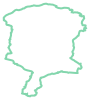

In [6]:
import fiona

# Open tracks layer
tracks_layer = fiona.open(fname, layer='tracks')
feature = tracks_layer[0]

# Print out the number of features in the tracks layer
print("# of features:\n--------------\n", len(list(tracks_layer.items())))

# Print out fields and attribute data
properties = feature['properties']
print("Feature attribute data:\n-----------------------")
for k, v in properties.items():
    print('{}: {}'.format(k,v))

# Draw a quick plot of data using shapely
from shapely.geometry import shape
tracks_data = {'type': 'MultiLineString',
               'coordinates': feature['geometry']['coordinates']}
tracks_shape = shape(tracks_data)
tracks_shape

perhaps we need to get the points into a separate geo dataframe

In [12]:
gdf_points = gpd.read_file(fname, layer='track_points')
gdf_points = gdf_points[['track_seg_point_id', 'ele', 'time', 'geometry']].copy()
gdf_points

track_seg_point_id        ele                 time  \
0                      0  78.800003  2020-06-16T11:12:51   
1                      1  78.800003  2020-06-16T11:12:52   
2                      2  78.800003  2020-06-16T11:12:54   
3                      3  79.000000  2020-06-16T11:12:57   
4                      4  78.400002  2020-06-16T11:13:01   
...                  ...        ...                  ...   
4351                4351  46.599998  2020-06-16T14:42:35   
4352                4352  46.599998  2020-06-16T14:42:38   
4353                4353  47.599998  2020-06-16T14:42:41   
4354                4354  48.599998  2020-06-16T14:42:43   
4355                4355  48.799999  2020-06-16T14:42:44   

                       geometry  
0     POINT (-0.93328 51.01343)  
1     POINT (-0.93323 51.01345)  
2     POINT (-0.93309 51.01348)  
3     POINT (-0.93289 51.01350)  
4     POINT (-0.93258 51.01355)  
...                         ...  
4351  POINT (-0.93205 51.01359)  
4352  POINT (-0.93231 51.01354)  
4353  POINT (-0.93256 51.01350)  
4354  POINT (-0.93271 51.01348)  
4355  POINT (-0.93278 51.01347)  

[4356 rows x 4 columns]

In [26]:
# time_change = pd.to_datetime(gdf_points.loc[x + 1, time], infer_datetime_format=True) - pd.to_datetime(gdf_points.loc[x, time], infer_datetime_format=True)
# time_change_seconds = time_change.seconds
time_change = pd.to_datetime(gdf_points['time']).diff()
time_change

0           NaT
1      00:00:01
2      00:00:02
3      00:00:03
4      00:00:04
         ...   
4351   00:00:01
4352   00:00:03
4353   00:00:03
4354   00:00:02
4355   00:00:01
Name: time, Length: 4356, dtype: timedelta64[ns]

In [13]:
import branca.colormap as cm
import math

f2 = folium.Figure(height = 400)
m2 = folium.Map([centre_lat, centre_long], zoom_start = 15)

# max_mph = math.ceil(gdf_line['mph'].max())
# linear = cm.linear.YlOrRd_04.scale(0,max_mph)
gps_lyr = folium.GeoJson(gdf_points,
                         style_function = lambda feature: {
                             'color': linear(feature['properties']['mph']),
                             'weight': 5})       

gps_lyr.add_child
    
m2.add_child(linear)
m2.add_child(gps_lyr)
m2.add_to(f2)

NameError: name 'linear' is not defined

Having managed to create LineStrings for each consecutive pair of points, I piggybacked on that process to calculate change in elevation and time between each point. I did this by expanding my make_lines() function to carry out those calculations and place the results into columns with the ouput DataFrame.

In [81]:
def make_lines(gdf, df_out, i, elevation = 'ele', time = 'time', geometry = 'geometry'):
    # Get track coordinates
    geom0 = gdf.loc[i][geometry]
    geom1 = gdf.loc[i + 1][geometry]
    
    # Create LineString from coordinates
    start, end = [(geom0.x, geom0.y), (geom1.x, geom1.y)]
    line = LineString([start, end])
    
    # Calculate change in elevation
    elevation_change = gdf.loc[i + 1, elevation] - gdf.loc[i, elevation]
    
    # Calculate time betweent segments
    time_change = pd.to_datetime(gdf.loc[i + 1, time], infer_datetime_format=True) - pd.to_datetime(gdf.loc[i, time], infer_datetime_format=True)
    time_change_seconds = time_change.seconds
    
    # Create a DataFrame to hold record
    data = {'id': i,
            'elevation_change': elevation_change,
            'time_change': time_change_seconds,
            'geometry': [line]}
    df_line = pd.DataFrame(data, columns = ['id', 'elevation_change', 'time_change','geometry'])
    
    # Add record DataFrame of compiled records
    df_out = pd.concat([df_out, df_line])
    return df_out

With a function for creating the segments and doing calculations, all I need to do was initialize a new DataFrame, df, that matched the schema of the DataFrame being returned by make_lines(). While df starts as an empty DataFrame, it is populated as a while-loop runs make_lines() on each consecutive pair of points.

In [79]:
df = pd.DataFrame(columns = ['id', 'elevation_change', 'time_change', 'geometry'])

x = 0
while x < len(gdf) - 1:
    df_input = make_lines(gdf, df, x)
    df = df_input
    x = x + 1

    
df.head()

id  elevation_change time_change  \
0  0               0.0           1   
0  1               0.0           1   
0  2               0.0           1   
0  3               0.0           1   
0  4               0.0           1   

                                            geometry  
0  LINESTRING (-0.933481 51.013545, -0.933481 51....  
0  LINESTRING (-0.933481 51.013545, -0.933481 51....  
0  LINESTRING (-0.933481 51.013545, -0.933481 51....  
0  LINESTRING (-0.933481 51.013545, -0.933481 51....  
0  LINESTRING (-0.933481 51.013545, -0.933481 51....

Although the final version of df had a geometry column containing shapely LineStrings, the DataFrame still needed to be converted into a GeoDataFrame for both plotting and for calculating the length of each segment. To convert df into a GeoDataFrame, gdf_line, I passed the DataFrame and the coordinate reference system of the geometry column to a geopandas GeoDataFrame():

In [83]:
# crs = {'init': 'epsg:4326'}
crs = ('epsg:4326')
gdf_line = GeoDataFrame(df, crs=crs)
gdf_line.head()


id  elevation_change time_change  \
0  0               0.0           1   
0  1               0.0           1   
0  2               0.0           1   
0  3               0.0           1   
0  4               0.0           1   

                                            geometry  
0  LINESTRING (-0.93348 51.01355, -0.93348 51.01355)  
0  LINESTRING (-0.93348 51.01355, -0.93348 51.01355)  
0  LINESTRING (-0.93348 51.01355, -0.93348 51.01355)  
0  LINESTRING (-0.93348 51.01355, -0.93348 51.01355)  
0  LINESTRING (-0.93348 51.01355, -0.93348 51.01355)

Although the geometry column in df and gdf_line look the same, by converting df to a GeoDataFrame, the geometry column changed from a pandas Series to a geopandas GeoSeries.

In [84]:
print("Field types:")
print(f">> df['geometry']: {str(type(df['geometry']))}")
print(f">> gdf_line['geometry']: {str(type(gdf_line['geometry']))}")


Field types:
>> df['geometry']: <class 'pandas.core.series.Series'>
>> gdf_line['geometry']: <class 'geopandas.geoseries.GeoSeries'>


In [85]:
folium.GeoJson(gdf_line).add_to(m)
m



We're in the home stretch here! While I had managed to create line segments and derived time and elevation change for each line segment, I was missing a key measure: speed.

Speed = Distance/Time

My desire was to calculate miles per hour for each segment. I already had time, albeit in seconds. I didn't have the distance along each segment. Fortunately, geopandas has a length method for calculating distance. The catch was that it calculates length in the units of GeoDataFrame's coordinate reference system (CRS). Because gdf_line is based on WGS84, its units were in degrees. Luckily I was able to use geopanda's to_crs() method to briefly transform gdf_line into a local, foot-based CRS, NAD83 / North Carolina. I calculated the length of each segment and converted the value into miles, miles_travled. I then created a new column, mph, by converting time_change from seconds to hours and dividing miles_traveled by that value. As a final step re-transformed gdf_line back to WGS84.


In [86]:
# convert to GeoDataFrame to a crs from which we can derive linear measurements
gdf_line = gdf_line.to_crs(epsg = 2264)
# calculate miles per hour for each segment. Distance is calculated in meters, time in seconds. 
# They are converted to miles and hours, respectively, when creating the speed (mph) column.
gdf_line['miles_traveled'] = gdf_line.length * 0.000189394
gdf_line['mph'] = gdf_line['miles_traveled'] / (gdf_line['time_change'] * 0.000277778)
# convert back to original crs
gdf_line = gdf_line.to_crs(epsg = 4326)
gdf_line.head()

id  elevation_change time_change  \
0  0               0.0           1   
0  1               0.0           1   
0  2               0.0           1   
0  3               0.0           1   
0  4               0.0           1   

                                            geometry  miles_traveled mph  
0  LINESTRING (-0.93348 51.01354, -0.93348 51.01354)             0.0   0  
0  LINESTRING (-0.93348 51.01354, -0.93348 51.01354)             0.0   0  
0  LINESTRING (-0.93348 51.01354, -0.93348 51.01354)             0.0   0  
0  LINESTRING (-0.93348 51.01354, -0.93348 51.01354)             0.0   0  
0  LINESTRING (-0.93348 51.01354, -0.93348 51.01354)             0.0   0

To check my work I plotted gdf_line using folium. I was especially interested to see if the speed for each segment seemed in line with my own experience, so I symbolized by the mph column using folium's color mapping functionality.

In [87]:
import branca.colormap as cm
import math

f2 = folium.Figure(height = 400)
m2 = folium.Map([centre_lat, centre_long], zoom_start = 15)

max_mph = math.ceil(gdf_line['mph'].max())
linear = cm.linear.YlOrRd_04.scale(0,max_mph)
gps_lyr = folium.GeoJson(gdf_line,
                         style_function = lambda feature: {
                             'color': linear(feature['properties']['mph']),
                             'weight': 5})       

gps_lyr.add_child
    
m2.add_child(linear)
m2.add_child(gps_lyr)
m2.add_to(f2)